# 03. VAR Model

**Mô hình:** Vector Autoregression (VAR)

**Thư viện:** statsmodels.tsa.api.VAR

**Metrics:** RMSFE, MAPE

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cấu hình hiển thị biểu đồ
plt.style.use('ggplot')
print("Đã import xong thư viện.")

Đã import xong thư viện.


In [18]:
# Đọc dữ liệu từ file CSV
# Giả sử file nằm cùng thư mục, nếu không hãy thay đổi đường dẫn
df_train = pd.read_csv('../data/processed/train_clean.csv')
df_test = pd.read_csv('../data/processed/test_clean.csv')

# Kiểm tra kích thước dữ liệu
print(f"Kích thước tập Train: {df_train.shape}")
print(f"Kích thước tập Test: {df_test.shape}")

# Xem qua vài dòng đầu
display(df_train.head())

Kích thước tập Train: (114, 64)
Kích thước tập Test: (29, 64)


,CPI,Core CPI - Services - Dining Out,Terms of Trade - Exports,Terms of Trade - Imports,Chicken Placements (thousands),Private Credit - ME - Consumption (mill US$),Private Credit - MN - Consumption (mill S/),Private Credit - MN - Mortgage (mill S/),Capacity Utilization - Food & Beverages,Electricity Production - Lima (GWh),...,"Dependent Worker (3-month MA, thousands)","Unpaid Worker (3-month MA, thousands)","Firms 1-10 Workers (3-month MA, thousands)","Firms 11-50 Workers (3-month MA, thousands)","Firms 51+ Workers (3-month MA, thousands)","Adequately Employed (3-month MA, thousands)","Underemployed (3-month MA, thousands)",Employment Ratio (3-month MA),Monthly Income (3-month MA),"Unemployment Rate (3-month MA, %)"
0,0.747613,1.508755,0.744155,0.291248,-1.290650,0.811908,0.627090,0.521121,-0.120108,0.235848,...,-0.340296,0.668145,0.124240,-1.020085,-0.180936,-0.026495,-0.043690,-0.035596,-0.029838,0.072148
1,0.593620,1.445590,-0.773490,0.540970,1.938858,0.577959,0.587184,1.282827,0.365388,0.737550,...,-0.010613,-0.724864,-0.276371,-0.091412,0.553230,0.296809,-0.830154,-0.150043,1.818387,0.041515
2,0.426189,1.397242,-0.415705,-0.022122,-1.123109,0.791480,0.168363,0.558576,-0.670381,-0.836627,...,0.121749,-0.877534,-0.010366,-0.265875,0.293444,-0.405763,0.738320,0.020430,-1.181883,-0.069863
3,0.250454,1.362035,-0.128222,-1.189944,1.007024,1.518488,1.545390,0.797170,0.623263,0.041818,...,0.146946,-0.034810,-0.010533,1.173531,-0.217854,-0.200362,0.516119,0.084415,-1.036517,-0.103756
4,0.084918,1.334015,-2.414165,-1.320177,-0.201801,0.892859,0.921326,1.165457,-0.317426,0.085385,...,0.156316,0.063271,-0.064034,-0.086973,0.144130,-0.173682,0.182811,-0.033464,-0.141761,-0.129309


In [19]:
target_columns = df_train.columns[:5] 

# Tạo dataset rút gọn cho VAR
train_data = df_train[target_columns].dropna()
test_data = df_test[target_columns].dropna()

print("Các cột được chọn để chạy VAR:", target_columns.tolist())

Các cột được chọn để chạy VAR: ['CPI', 'Core CPI - Services - Dining Out', 'Terms of Trade - Exports', 'Terms of Trade - Imports', 'Chicken Placements (thousands)']


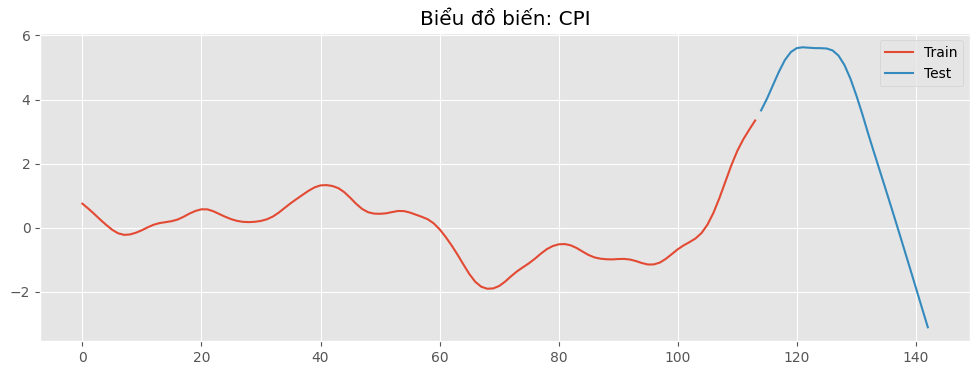

In [20]:
# Kiểm tra sơ bộ biểu đồ của biến mục tiêu chính (ví dụ cột đầu tiên)
plt.figure(figsize=(12, 4))
plt.plot(train_data.iloc[:, 0], label='Train')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data.iloc[:, 0], label='Test')
plt.title(f'Biểu đồ biến: {train_data.columns[0]}')
plt.legend()
plt.show()

In [21]:
# Khởi tạo mô hình VAR
model = VAR(train_data)

# Tự động chọn bậc trễ (lag) tối ưu hoặc set cứng (ví dụ maxlags=5)
# Nếu dữ liệu ít, hãy giảm maxlags xuống
lag_order_results = model.select_order(maxlags=2)
print(lag_order_results.summary())

# Chọn bậc trễ tốt nhất theo AIC
optimal_lag = lag_order_results.aic
print(f"\nBậc trễ tối ưu (AIC) được chọn: {optimal_lag}")

# Fit mô hình với bậc trễ đã chọn
var_model = model.fit(optimal_lag)

# Xem kết quả tóm tắt
print(var_model.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     -0.6943     -0.5730      0.4994     -0.6451
1      -11.52      -10.80   9.895e-06      -11.23
2     -16.58*     -15.24*  6.343e-08*     -16.03*
-------------------------------------------------

Bậc trễ tối ưu (AIC) được chọn: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Nov, 2025
Time:                     20:36:04
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -15.2416
Nobs:                     112.000    HQIC:                  -16.0349
Log likelihood:           188.683    FPE:                6.34256e-08
AIC:                     -16.5766    Det(Omega_mle):     3.97036e-08
--------------------------------------------------------------------
Results for equation CPI
 

In [22]:
# Lấy dữ liệu trễ cần thiết từ cuối tập train để dự báo
lag_order = var_model.k_ar
input_data = train_data.values[-lag_order:]

# Thực hiện dự báo cho số bước bằng độ dài tập test
n_obs = len(test_data)
pred = var_model.forecast(y=input_data, steps=n_obs)

# Chuyển kết quả về DataFrame để dễ so sánh
df_forecast = pd.DataFrame(pred, index=test_data.index, columns=test_data.columns + '_pred')

print("Dữ liệu dự báo (5 dòng đầu):")
display(df_forecast.head())

Dữ liệu dự báo (5 dòng đầu):


,CPI_pred,Core CPI - Services - Dining Out_pred,Terms of Trade - Exports_pred,Terms of Trade - Imports_pred,Chicken Placements (thousands)_pred
0,3.569072,1.096646,-0.212916,0.401079,-0.120373
1,3.721105,1.455847,-0.083820,0.303635,0.297774
2,3.809939,1.812280,-0.269071,0.255643,0.052618
3,3.836439,2.161478,-0.304340,0.148580,0.179832
4,3.801200,2.498512,-0.433943,0.037899,0.162494


In [28]:
import pandas as pd
import numpy as np

# --- LỰA CHỌN VÀ CHUẨN BỊ DỮ LIỆU ---

# 1. Chọn biến mục tiêu để trực quan hóa
# MẶC ĐỊNH: Chọn cột đầu tiên trong dữ liệu test (thường là biến mục tiêu chính)
VAR_PLOT_TARGET = test_data.columns[0] 
VAR_PRED_COL = VAR_PLOT_TARGET + '_pred'

# 2. Lấy dữ liệu thực tế và dự báo
try:
    y_true_var = test_data[VAR_PLOT_TARGET]
    y_pred_var = df_forecast[VAR_PRED_COL]
    
    # Đảm bảo index khớp nếu cần thiết
    y_pred_var.index = y_true_var.index
    
    print(f"Đã chọn biến mục tiêu: '{VAR_PLOT_TARGET}'")
    print(f"Kích thước dữ liệu thực tế: {y_true_var.shape}")
except KeyError as e:
    print(f"Lỗi: Không tìm thấy cột {e} trong dữ liệu dự báo/thực tế.")
    y_true_var = None
    y_pred_var = None

Đã chọn biến mục tiêu: 'CPI'
Kích thước dữ liệu thực tế: (29,)


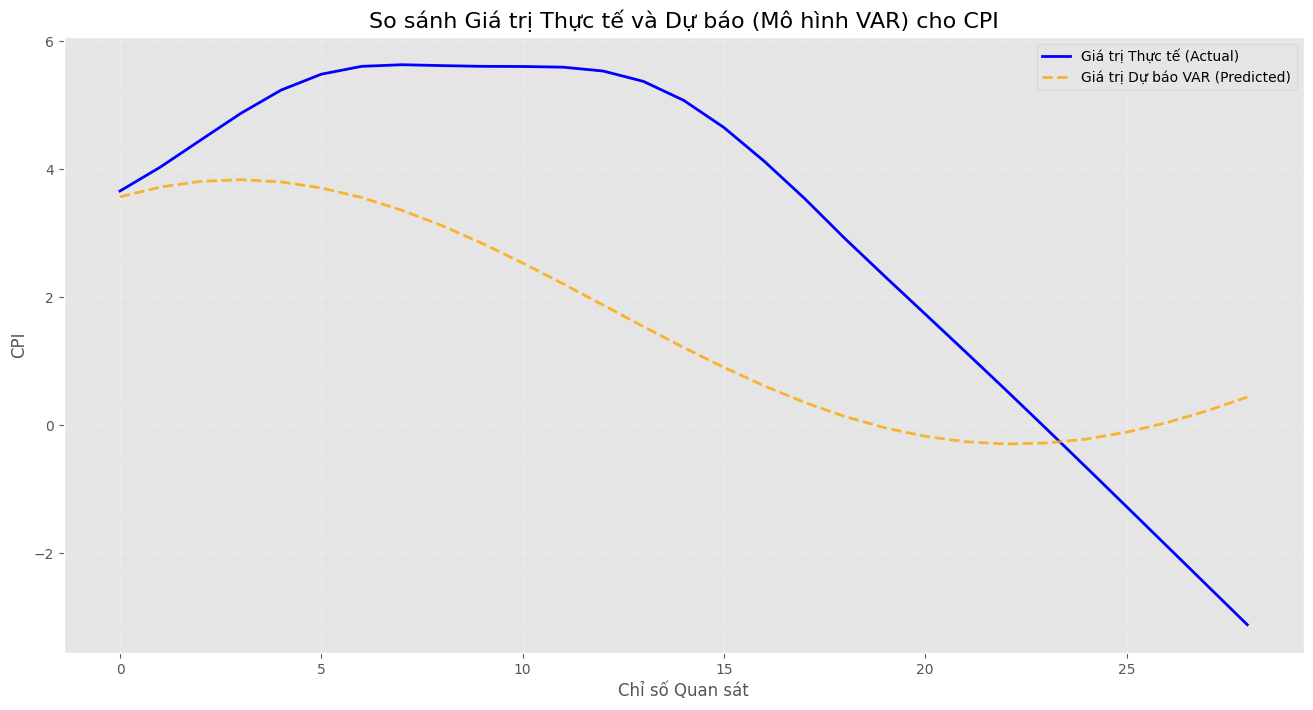

In [29]:
import matplotlib.pyplot as plt

if y_true_var is not None:
    plt.figure(figsize=(16, 8))
    
    # 1. Vẽ giá trị thực tế
    plt.plot(y_true_var.index, y_true_var.values, 
             label='Giá trị Thực tế (Actual)', 
             color='blue', 
             linewidth=2)
    
    # 2. Vẽ giá trị dự báo
    plt.plot(y_pred_var.index, y_pred_var.values, 
             label='Giá trị Dự báo VAR (Predicted)', 
             color='orange', 
             linestyle='--', 
             alpha=0.8, 
             linewidth=2)
    
    # 3. Định dạng biểu đồ
    plt.title(f'So sánh Giá trị Thực tế và Dự báo (Mô hình VAR) cho {VAR_PLOT_TARGET}', fontsize=16)
    plt.xlabel('Chỉ số Quan sát', fontsize=12)
    plt.ylabel(VAR_PLOT_TARGET, fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
else:
    print("Bỏ qua vẽ biểu đồ do lỗi dữ liệu hoặc biến mục tiêu chưa được chọn thành công ở Cell 7.")

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- 0. KHỞI TẠO THƯ MỤC LƯU TRỮ ---
OUTPUT_DIR_FIGURE = '../results/figures'
OUTPUT_DIR_TABLE = '../results/tables'
os.makedirs(OUTPUT_DIR_FIGURE, exist_ok=True)
os.makedirs(OUTPUT_DIR_TABLE, exist_ok=True)

if 'var_model' in locals() and var_model is not None:
    # Lấy dữ liệu cho biến mục tiêu chính (Giả định là cột đầu tiên)
    target_col_var = test_data.columns[0]
    target_col_pred = target_col_var + '_pred'
    y_true_var = test_data[target_col_var]
    y_pred_var = df_forecast[target_col_pred]
    
    # Tính toán metrics VAR
    rmse_var = calculate_rmsfe(y_true_var, y_pred_var)
    r2_var = r2_score(y_true_var, y_pred_var)
    mae_var = mean_absolute_error(y_true_var, y_pred_var)
    rmsfe_var = rmse_var
    mape_var = calculate_mape(y_true_var, y_pred_var)
    
    # 1. Tạo DataFrame kết quả VAR
    results_data_var = {
        'Model': ['VAR'],
        'Lag_Order': [var_model.k_ar],
        'R-squared': [r2_var],
        'RMSE': [rmse_var],
        'RMSFE': [rmsfe_var],
        'MAE': [mae_var],
        'MAPE (%)': [mape_var],
        'Target_Variable': [target_col_var]
    }
    df_results_var = pd.DataFrame(results_data_var)
    
    # 2. Lưu Bảng VAR vào thư mục 'tables'
    table_filename_var = os.path.join(OUTPUT_DIR_TABLE, 'var_model_summary.csv')
    df_results_var.to_csv(table_filename_var, index=False)
    
    # 3. Lưu Biểu đồ VAR vào thư mục 'figures'
    plt.figure(figsize=(16, 8))
    plt.plot(y_true_var, label='Thực tế', color='blue', linewidth=2)
    plt.plot(y_pred_var, label='Dự báo VAR', color='orange', linestyle='--', alpha=0.8, linewidth=2)
    plt.title(f'Dự báo Mô hình VAR cho {target_col_var}')
    plt.xlabel('Chỉ số Quan sát'); plt.ylabel(target_col_var); plt.legend(); plt.grid(True)
    figure_filename_var = os.path.join(OUTPUT_DIR_FIGURE, 'var_forecast_plot.png')
    plt.savefig(figure_filename_var, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"\n[VAR] Đã lưu bảng metrics vào '{table_filename_var}'")
    print(f"[VAR] Đã lưu biểu đồ vào '{figure_filename_var}'")
else:
    print("\n[VAR] Bỏ qua vì mô hình chưa được huấn luyện thành công.")
    df_results_var = pd.DataFrame()

Đã tạo thư mục '../results/figures' và '../results/tables'.

[VAR] Đã lưu bảng metrics vào '../results/tables\var_model_summary.csv'
[VAR] Đã lưu biểu đồ vào '../results/figures\var_forecast_plot.png'
